In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

sns.set(style="whitegrid")

In [3]:
# Load dataset
df = pd.read_csv('Fake.csv')  # Update path if needed
df = df[['title', 'text', 'subject']].dropna()

# Combine title + text
df['content'] = df['title'] + " " + df['text']

# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['subject'])

print("Dataset info:")
display(df.head())
print("\nLabel distribution:")
print(df['subject'].value_counts())

Dataset info:


,title,text,subject,content,label_encoded
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,Donald Trump Sends Out Embarrassing New Year’...,2
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,Drunk Bragging Trump Staffer Started Russian ...,2
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,Sheriff David Clarke Becomes An Internet Joke...,2
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,Trump Is So Obsessed He Even Has Obama’s Name...,2
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,Pope Francis Just Called Out Donald Trump Dur...,2



Label distribution:
subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64


/tmp/ipython-input-1759108551.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='subject', data=df, palette='Set2', order=df['subject'].value_counts().index)


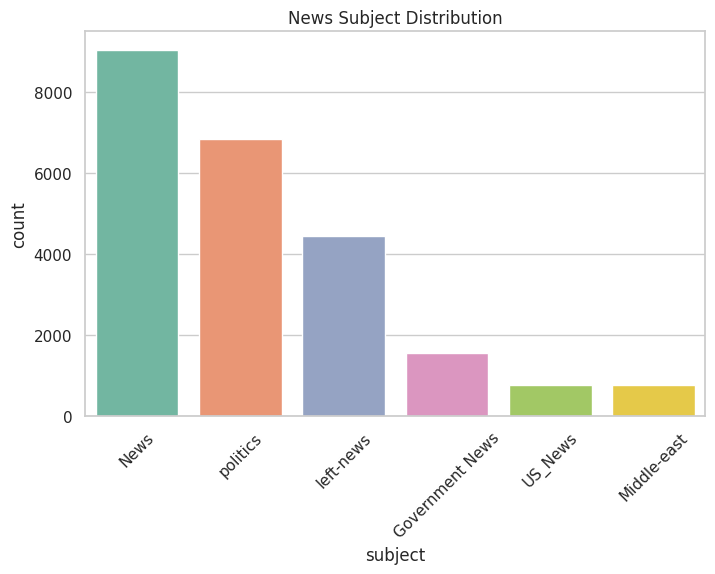

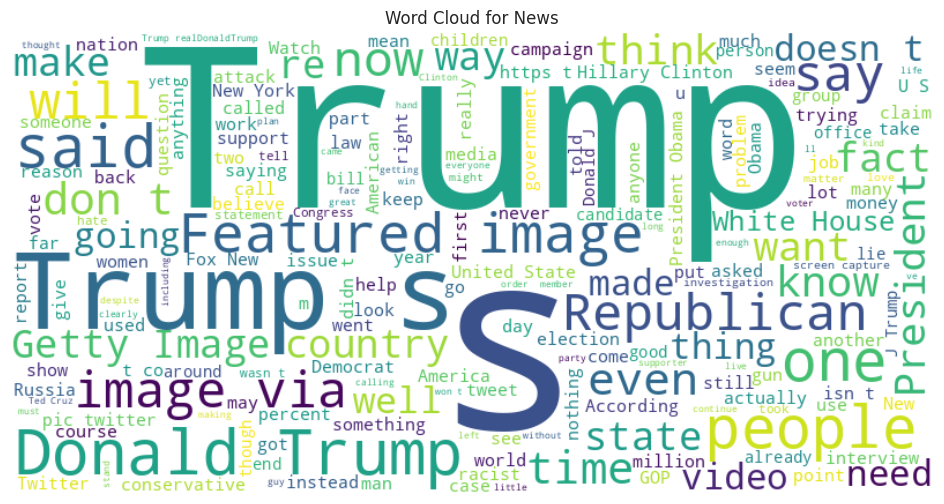

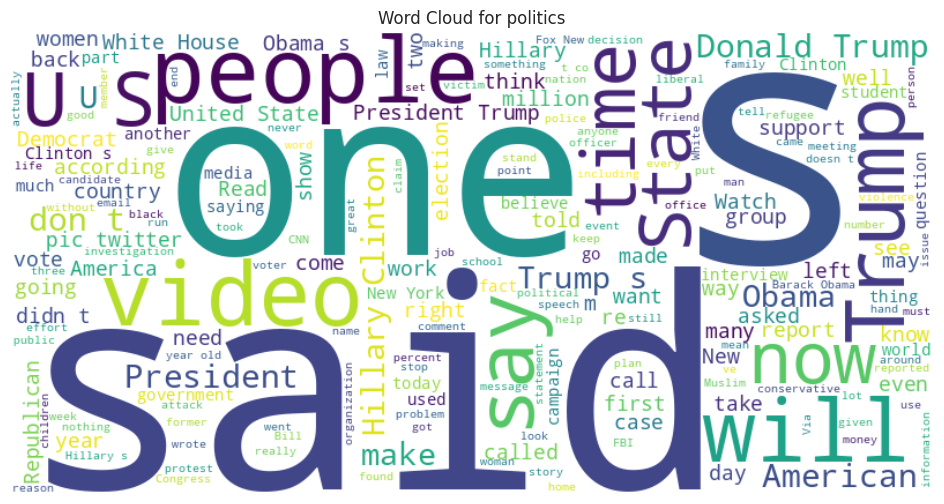

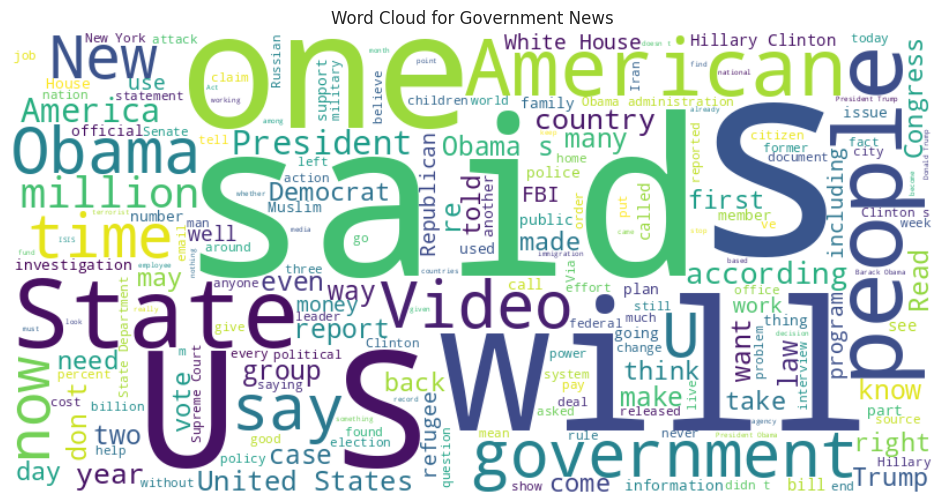

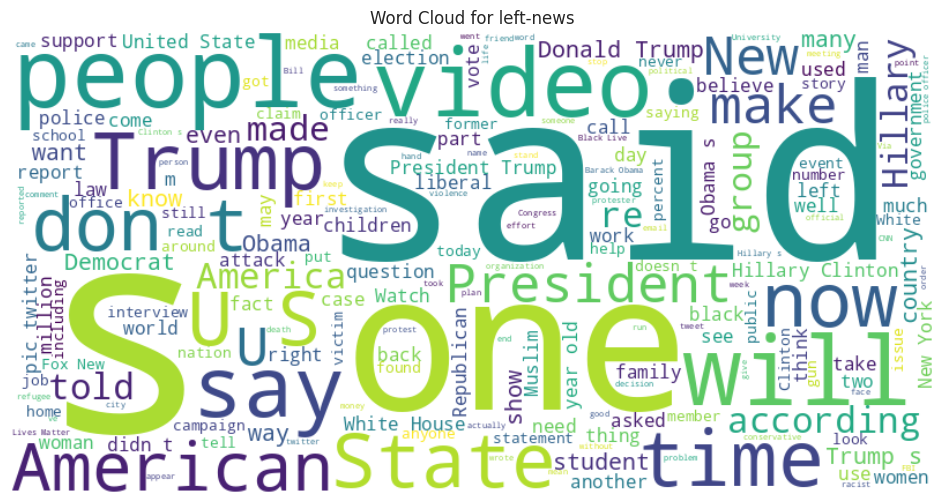

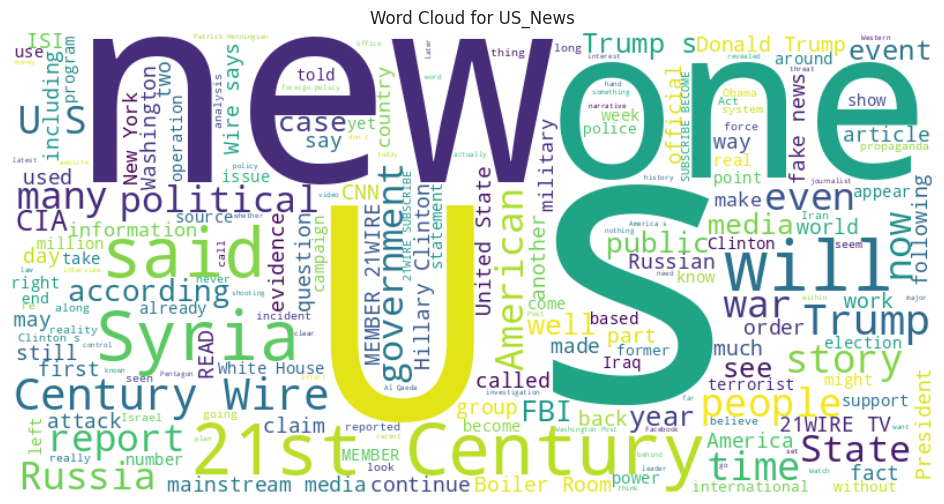

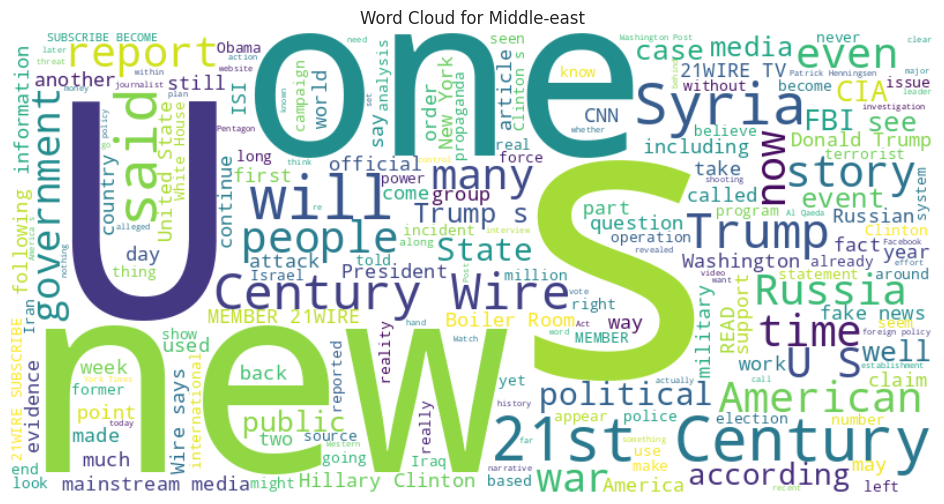

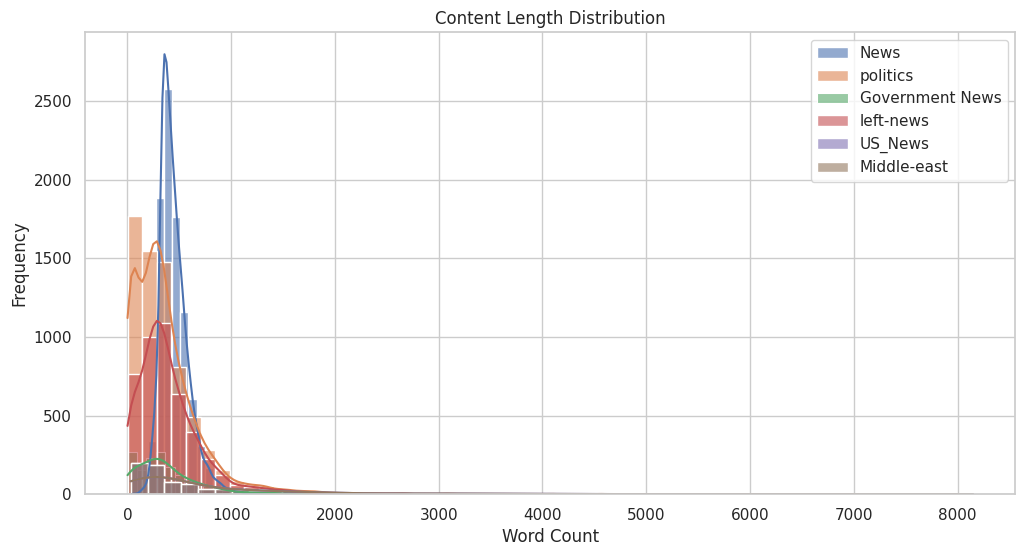

In [4]:
# Label distribution
plt.figure(figsize=(8,5))
sns.countplot(x='subject', data=df, palette='Set2', order=df['subject'].value_counts().index)
plt.title("News Subject Distribution")
plt.xticks(rotation=45)
plt.show()

# Word clouds per subject
subjects = df['subject'].unique()
for subject in subjects:
    text = ' '.join(df[df['subject']==subject]['content'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text)
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {subject}")
    plt.axis('off')
    plt.show()

# Content length analysis
df['content_length'] = df['content'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12,6))
for subject in subjects:
    sns.histplot(df[df['subject']==subject]['content_length'], label=subject, kde=True, bins=50, alpha=0.6)
plt.title("Content Length Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df['content'], df['label_encoded'], test_size=0.2, random_state=42, stratify=df['label_encoded']
)

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt', max_length=512)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, return_tensors='pt', max_length=512)

# Datasets
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(y_train.values))
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(y_test.values))

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
# Device
device = torch.device('cpu')
print("Using device:", device)

Using device: cpu


In [7]:
# Number of labels
num_labels = df['label_encoded'].nunique()

# Model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Training loop
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    print(f"\nEpoch {epoch+1}/{epochs} Training...")
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")

print("Training completed successfully on CPU!")


Epoch 1/3 Training...


In [2]:
model.eval()
predictions, true_labels = [], []

for batch in test_loader:
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    predictions.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(range(len(label_encoder.classes_)), label_encoder.classes_, rotation=45)
plt.yticks(range(len(label_encoder.classes_)), label_encoder.classes_)
for i in range(len(label_encoder.classes_)):
    for j in range(len(label_encoder.classes_)):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='red')
plt.show()

In [ ]:
for subject in subjects:
    text = ' '.join(df[df['subject']==subject]['content'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text)
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {subject}")
    plt.axis('off')
    plt.show()